In [1]:
import numpy as np
import pickle
%matplotlib inline
import cv2

In [2]:
with open('single_lane_recording_640_480.pkl') as f:
    source = pickle.load(f)
    


In [3]:
def get_inverse_perspective_transform(): 
    return Controller.get_perspective_transform(inverse=True)


def get_perspective_transform(inverse=False):        
    p1 = (232, 380) # top left
    p2 = (360, 380) # top right
    p3 = (206, 414) # bottom left
    p4 = (383, 414) # bottom right

    pts1 = np.float32([list(p1),list(p2),list(p3),list(p4)])
    output_width = 100
    output_height = 35
    dx=289
    dy=585
    pts2 = np.float32([[dx,dy],[dx+output_width,dy],[dx,dy+output_height],[dx+output_width,dy+output_height]])
    if inverse:
        M = cv2.getPerspectiveTransform(pts2,pts1)
    else:
        M = cv2.getPerspectiveTransform(pts1,pts2)
    return M


def transform_anchor_points(points, M):
    points = np.array(points, dtype=np.float32)
    transformed = cv2.perspectiveTransform(points[None, :, :], M)
    return transformed.tolist()[0]


def compute_topdown_image(image_filename, transformation_matrix, transformation_size):
    img = cv2.imread(image_filename)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    dst = cv2.warpPerspective(img, transformation_matrix, (transformation_size , transformation_size))
    dst = cv2.cvtColor(dst, cv2.cv.CV_BGR2RGB)
    return dst

In [4]:
def crop(image, anchor_points, crop_size, shift_percentage):
    """
    shift is shift from center
    """
    image_width = image.shape[1]
    max_shift = (image_width - crop_size[1])/2.0
    
#     print "maxshift"
#     print max_shift
    # left x for when the crop window is centered
    x_left_image_center = max_shift
    shift = shift_percentage*max_shift
    
    # max
    x_left = x_left_image_center + shift
    x_right = x_left+crop_size[1]
    

    anchor_points = np.copy(anchor_points)
    anchor_points[:,0] = anchor_points[:, 0] - (x_left)
    
#     print x_left
#     print shift
    cropped = np.copy(image[:crop_size[0],x_left:x_right])
    return cropped, anchor_points

    #crop the center of the image    
def resize(image, anchor_points, scale):
    anchor_points = anchor_points * scale
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    return image, anchor_points

def change_perspective(image, anchor_points, transformation, transformation_size):
    anchor_points = cv2.perspectiveTransform(anchor_points[None, :, :], transformation)[0]
    image = cv2.warpPerspective(image, transformation, transformation_size)
    return image, anchor_points
    
def get_anchor_points(source, image_file, use_front=False):
    splines = [lane['anchor_points'] for lane in source['lanes'][image_file].values()]
    anchor_points = [anchor_point for spline in splines for anchor_point in spline ]
    anchor_points = 1.0*np.array(anchor_points)
#     print '1'
#     print anchor_points    
    if use_front:
        transformation = topdown_to_front_transformation = source['topdown_to_front_transformation']
        anchor_points = cv2.perspectiveTransform(anchor_points[None, :, :], transformation)[0]
#     print '2'
#     print anchor_points          
    return anchor_points
        
def calculate_displacements(image, anchor_points):
    center_x = image.shape[1]/2.0
    displacements = anchor_points[:,0] - center_x
    return displacements

def create_image_data(image, anchor_points, size, shift_percentage):
    scale = (1.0*size[0])/image.shape[0]
    image, anchor_points = resize(image, anchor_points, scale)
#     print 'C'
#     print anchor_points    
    image, anchor_points = crop(image, anchor_points, size, shift_percentage)
#     print 'D'
#     print anchor_points     
    displacements = calculate_displacements(image, anchor_points)
    image = 1.0*np.expand_dims(image, axis=0)
    return image, anchor_points, displacements



In [7]:
import lmdb
import msgpack
import msgpack_numpy as m
m.patch()
import numpy as np
import random
import shutil
import os
def create_dataset(save_file, images, source, size=(224,224), shuffle=False, data_max=None, data_min=None, num_shifts=1, use_front=False):    
    n = len(images)*(1+num_shifts)
    map_size = n * size[0]*size[1]*8 * 20

    if os.path.exists(save_file):
        shutil.rmtree(save_file)

    env = lmdb.open(save_file, map_size=map_size)
    
    transformation_size = source['transformation_size']
    front_to_topdown_transformation = source['front_to_topdown_transformation']
    topdown_to_front_transformation = source['topdown_to_front_transformation']  
    with env.begin(write=True) as txn:
        txn.put('num_records', str(n))
        for i in range(len(images)):
            shift_percentages = (np.random.random(num_shifts+1)*2)-1
            shift_percentages[0] = 0
            image_file = images[i]
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.cv.CV_BGR2RGB)
            anchor_points = get_anchor_points(source, image_file, use_front=use_front)
            if not use_front:
                image, _ = change_perspective(image, anchor_points, front_to_topdown_transformation, transformation_size)
            for j in range(len(shift_percentages)):

                sample_anchor_points = np.copy(anchor_points)
                shift_percentage = shift_percentages[j]
                image_data, sample_anchor_points, displacements = create_image_data(image, sample_anchor_points, size, shift_percentage)  
                image_index = i*(1+num_shifts) + j
                sample = {
                    'image': images,
                    'image_data' : image_data, 
                    'image_targets' : displacements, 
                    'shift_percentage' : shift_percentage,
                    'anchor_points' : sample_anchor_points
                }
                sample_encoded = msgpack.packb(sample, default=m.encode)
                txn.put(str(image_index), sample_encoded)
                if image_index %
    
        print "Normalizing"
        targets = np.zeros((n, 6))
        low = 0.1
        high = 0.9    
        for image_index in range(n):
            sample_encoded = txn.get(str(image_index))            
            sample = msgpack.unpackb(sample_encoded, object_hook=m.decode)
            targets[image_index,:] = sample['image_targets']
            
        normalized_targets, data_min, data_max = normalize_to_range(targets, low, high, data_min=data_min, data_max=data_max)
        txn.put('low', str(low))
        txn.put('high', str(high))
        txn.put('data_max', str(data_max))
        txn.put('data_min', str(data_min))
        for image_index in range(n):
            sample_encoded = txn.get(str(image_index))            
            sample = msgpack.unpackb(sample_encoded, object_hook=m.decode)
            sample['targets'] = normalized_targets[image_index]
            sampled_encoded = msgpack.packb(sample, default=m.encode)
            txn.put(str(image_index), sample_encoded)
    return data_min, data_max
            

def normalize_to_range(data,low, high, data_min=None, data_max=None):
    # Normalize to [0, 1]:
    if data_min is None:
        data_min = np.min(data, axis=0)
    if data_max is None:
        data_max = np.max(data, axis=0)
    data_range = data_max-data_min
    data = (data - data_min) / data_range;
    # Then scale to [x,y]:
    target_range = high - low;
    data = (data*target_range) + low;
    return data, data_min, data_max

def unnormalize(data, low, high, data_min, data_max):
    target_range = high - low;
    data = (data -low)/target_range
    data_range = data_max-data_min
    data = (data*data_range) + data_min
    return data
    

In [9]:
train_files = source['image_files'][:1500]
test_files = source['image_files'][1501:1750]
fields = ['images','image_data', 'targets', 'max', 'min']
import time
start = time.time()
data_min, data_max = create_dataset('train_large.lmdb', train_files, source, size=(224,224), num_shifts=10, use_front=True)
end = time.time()
print end-start


/home/blake/VirtualEnvs/varden/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


96.2532608509


In [9]:
create_dataset('test.lmdb', test_files,  source, size=(224,224), num_shifts=10, data_min=data_min, data_max=data_max, use_front=True) 

/home/blake/VirtualEnvs/varden/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(array([ -54.26607642,  -67.07181752, -132.11259418,  -39.59216751,
         -30.6173504 ,    1.72031722]),
 array([ 23.79007816,  12.1595085 , -34.29889136,  38.26055111,
         48.70204855,  96.38501036]))

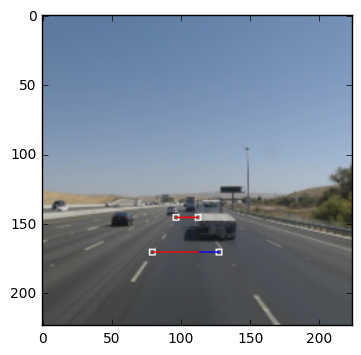

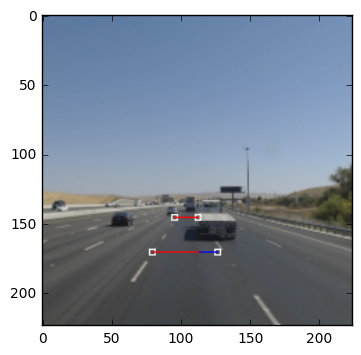

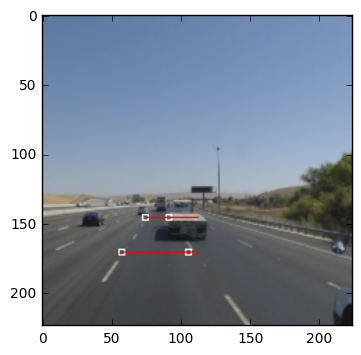

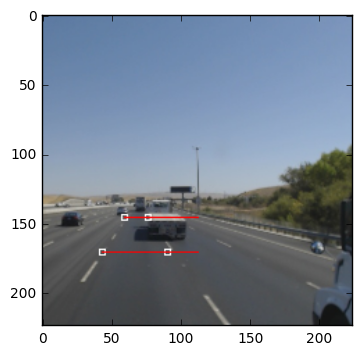

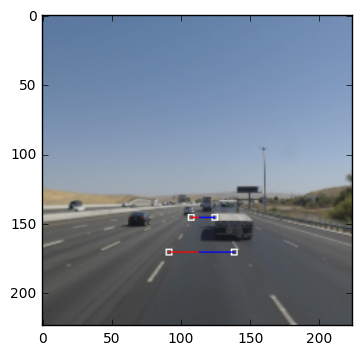

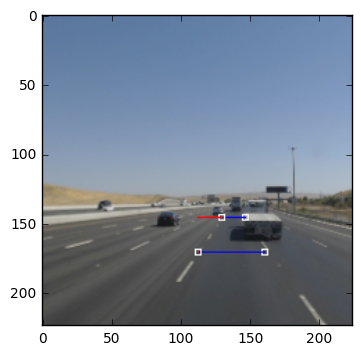

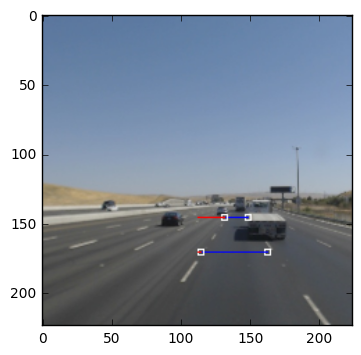

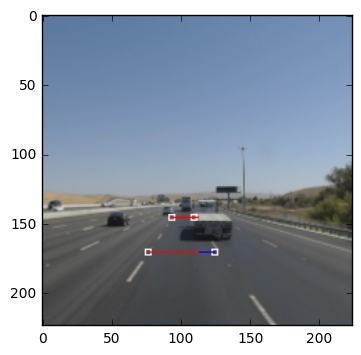

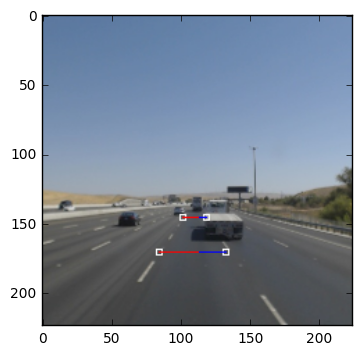

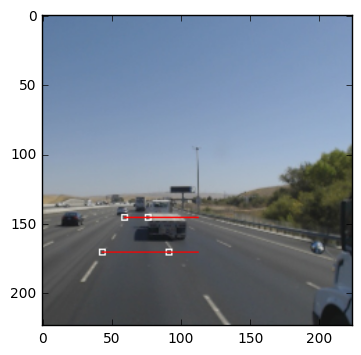

In [633]:
for i in range(10):
    display_anchor_points(dataset, i)

In [1]:


def display_anchor_points(dataset, index):
    image = dataset['image_data'][index].astype('uint8')
    center_x = image.shape[1]/2
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image) 
    anchor_points = dataset['anchor_points'][index]
    targets = dataset['image_targets'][index]
    targets = unnormalize(targets, dataset['low'],dataset['high'],dataset['data_min'],dataset['data_max'])
    for i in range(anchor_points.shape[0]):
        color = (255,0,0) if i >=3 else (0,0,255)
        anchor_point = anchor_points[i].astype(int)
        dy = 2
        dx = 2
        rect = [anchor_point[0]-dx, anchor_point[1]-dy,anchor_point[0]+dx, anchor_point[1]+dy]
        draw.rectangle(rect)  
        
        y = anchor_point[1]
        start = center_x
        end = start + targets[i]
        line = [ start, y, end, y]
        draw.line(line, fill=color, width=1)  
    plt.figure()
    plt.imshow(image)
    


In [2]:
import msgpack
import msgpack_numpy as m
m.patch()
import numpy as np
import random

In [9]:
a={"dog":123, "poo": "poo", 'm': np.random.random((224,224))}

In [15]:
x_encoded = msgpack.packb(a, default=m.encode)

In [16]:
x_decoded = msgpack.packb(x_encoded, object_hook=m.decode)

TypeError: __init__() got an unexpected keyword argument 'object_hook'

In [18]:

x = a
x_enc = msgpack.packb(x, default=m.encode)
x_rec = msgpack.unpackb(x_enc, object_hook=m.decode)

In [143]:
(np.random.random()*2)-1

-0.17105539159474037

In [144]:
a=np.array([[1,2.],[3,4]])

In [145]:
a

array([[ 1.,  2.],
       [ 3.,  4.]])

In [146]:
a *np.array([0,2])

array([[ 0.,  4.],
       [ 0.,  8.]])